# Basic PINN implementation

In [1]:
import torch.nn as nn
import torch.optim as optim
from torch import vmap
from torch.func import jacrev
import torch
from compute_error import compute_error_norms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def ODE_1(t, y): # Exponential decay
    # y: R^1, lambda: 0.1
    y = torch.tensor(y, dtype=torch.float32).to(device)
    return -0.1 * y

ODE_1_y0 = torch.tensor([2.0]).to(device)

def ODE_2(t, y): # Van der Pol Oscillator
    # y: R^2, mu: 2
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32).to(device)
    
    x = y[0]
    dy = y[1]
    # Parameters
    omega = 1.0
    zeta = 0.5
    
    dydt = torch.stack([dy, -omega**2 * x - 2 * zeta * omega * dy]).to(device)
    return dydt

ODE_2_y0 = torch.tensor([2.0, 0.0]).to(device)

In [3]:
class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs,
        num_layers,
        num_neurons,
        num_outputs,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Basic neural network architecture with linear layers
        
        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # output layer
        layers.append(nn.Linear(num_neurons, num_outputs))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()

In [4]:
"""

# Assuming T is defined somewhere
T = 10.0

# Sample input tensor with requires_grad=True
t = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32, requires_grad=True)

# Define the function f
def f(x):
    y1 = x**2
    y2 = x**3
    return torch.stack([y1, y2], dim=-1)  # Shape [2]

# Define the Jacobian function for a single input
def jacobian_fn(x):
    return jacrev(model)(x)

# Use vmap to compute Jacobians for each element in the batch
batched_jacobian_fn = vmap(jacobian_fn)



jacobians = batched_jacobian_fn(t)

# The result should be of shape [batch_size, 2, 1] (since each element has 2 outputs and 1 input)
# We want the gradient which is the Jacobian in this case, squeeze the last dimension
gradients = jacobians.squeeze(-1)

# The result should be of shape [batch_size, 2]
print(gradients)
"""


'\n\n# Assuming T is defined somewhere\nT = 10.0\n\n# Sample input tensor with requires_grad=True\nt = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32, requires_grad=True)\n\n# Define the function f\ndef f(x):\n    y1 = x**2\n    y2 = x**3\n    return torch.stack([y1, y2], dim=-1)  # Shape [2]\n\n# Define the Jacobian function for a single input\ndef jacobian_fn(x):\n    return jacrev(model)(x)\n\n# Use vmap to compute Jacobians for each element in the batch\nbatched_jacobian_fn = vmap(jacobian_fn)\n\n\n\njacobians = batched_jacobian_fn(t)\n\n# The result should be of shape [batch_size, 2, 1] (since each element has 2 outputs and 1 input)\n# We want the gradient which is the Jacobian in this case, squeeze the last dimension\ngradients = jacobians.squeeze(-1)\n\n# The result should be of shape [batch_size, 2]\nprint(gradients)\n'

In [4]:
model = LinearNN(1, 4, 64, 2).to(device)

# Define the Jacobian function for a single input
def jacobian_fn(x):
    return jacrev(model)(x)

# Use vmap to compute Jacobians for each element in the batch
batched_jacobian_fn = vmap(jacobian_fn)

In [6]:
"""
model = LinearNN(1, 1, 64, 1)

def f(t: torch.Tensor, params: dict[str, torch.nn.Parameter]) -> torch.Tensor:
    return functional_call(model, params, (t, ))

dfdx = vmap(grad(f), in_dims=(0, None))

# use like this: grads = dfdx(t, params)

def compute_gradients(t: torch.Tensor, f):
    # Compute model output
    #f = model(t)  # Output shape: [batchsize, num_output_params]

    # Initialize a tensor to hold the gradients
    gradients = torch.zeros_like(f)

    # Compute the gradient for each output with respect to the input t
    for i in range(f.shape[1]):  # Loop over the output features
        grad_outputs = torch.zeros_like(f)
        grad_outputs[:, i] = 1.0  # Set the appropriate output to 1

        # Compute the gradients
        f.backward(grad_outputs, retain_graph=True)
        
        # Collect the gradients
        gradients[:, i] = t.grad

        # Clear the gradients for the next iteration
        t.grad.zero_()

    return gradients

def compute_gradients_2(t: torch.Tensor):
    
    f = model(t)
    if len(f.shape) == 1:
        f = f[:, None]
    
    out = torch.zeros_like(f)
    
    for i in range(f.shape[0]):
        y = f[i, :]
        y_t = torch.autograd.grad(
                y, t[i], 
                grad_outputs=torch.ones_like(y),
                retain_graph=True,
                create_graph=True,
                allow_unused=True
            )[0]
        print(y_t.shape)
        out[i, :] = y_t
    
    t.grad.zero_()
    
    return out
"""

'\nmodel = LinearNN(1, 1, 64, 1)\n\ndef f(t: torch.Tensor, params: dict[str, torch.nn.Parameter]) -> torch.Tensor:\n    return functional_call(model, params, (t, ))\n\ndfdx = vmap(grad(f), in_dims=(0, None))\n\n# use like this: grads = dfdx(t, params)\n\ndef compute_gradients(t: torch.Tensor, f):\n    # Compute model output\n    #f = model(t)  # Output shape: [batchsize, num_output_params]\n\n    # Initialize a tensor to hold the gradients\n    gradients = torch.zeros_like(f)\n\n    # Compute the gradient for each output with respect to the input t\n    for i in range(f.shape[1]):  # Loop over the output features\n        grad_outputs = torch.zeros_like(f)\n        grad_outputs[:, i] = 1.0  # Set the appropriate output to 1\n\n        # Compute the gradients\n        f.backward(grad_outputs, retain_graph=True)\n        \n        # Collect the gradients\n        gradients[:, i] = t.grad\n\n        # Clear the gradients for the next iteration\n        t.grad.zero_()\n\n    return gradien

In [5]:
ODE_batch = vmap(ODE_2, in_dims=0)

In [6]:
def loss_fn(t: torch.Tensor):
    # INTERIOR LOSS
    # NN grads
    y = model(t)
    
    jacobians = batched_jacobian_fn(t)
    dydt = jacobians.squeeze(-1)
    # ODE actual grads
    ode_grads = ODE_batch(t, y)
    interior = dydt - ode_grads
    
    # BOUNDARY LOSS
    y_0 = model(torch.tensor([0.0]).to(device))
    
    boundary = y_0 - ODE_2_y0
    
    lambda_i = 1.0
    lambda_b = 0.5
    
    loss = nn.MSELoss(reduction='mean')
    interior_loss = loss(interior, torch.zeros_like(interior))
    boundary_loss = loss(boundary, torch.zeros_like(boundary))
    
    return lambda_i * interior_loss + lambda_b * boundary_loss
    

In [7]:
batch_size = 128  # number of colocation points to sample in the domain
num_iter = 500  # maximum number of iterations
learning_rate = 1e-2  # learning rate
weight_decay = 1e-4  # weight decay
T = 10  # final time

optimzier = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


for i in range(num_iter):
    t = (torch.rand(batch_size) * T).to(device) 
    t.to(device)
    t.requires_grad_(True)
    
    loss = loss_fn(t)
    loss.backward()
    optimzier.step()
    optimzier.zero_grad()
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

/home/vedo/miniconda3/envs/thesis/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718580740865/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration 0, Loss: 1.0260087251663208
Iteration 10, Loss: 0.20414438843727112
Iteration 20, Loss: 0.02926267310976982
Iteration 30, Loss: 0.012361539527773857
Iteration 40, Loss: 0.007038889452815056
Iteration 50, Loss: 0.005463734269142151
Iteration 60, Loss: 0.004327794071286917
Iteration 70, Loss: 0.003135466715320945
Iteration 80, Loss: 0.0018758737714961171
Iteration 90, Loss: 0.0019351104274392128
Iteration 100, Loss: 0.002128442283719778
Iteration 110, Loss: 0.0009449758799746633
Iteration 120, Loss: 0.0022004800848662853
Iteration 130, Loss: 0.000777187931817025
Iteration 140, Loss: 0.0007436535088345408
Iteration 150, Loss: 0.0004923125961795449
Iteration 160, Loss: 0.04161795601248741
Iteration 170, Loss: 0.014877396635711193
Iteration 180, Loss: 0.0023373649455606937
Iteration 190, Loss: 0.0035740002058446407
Iteration 200, Loss: 0.0021638802718371153
Iteration 210, Loss: 0.00149965297896415
Iteration 220, Loss: 0.0014704617206007242
Iteration 230, Loss: 0.001796762691810727

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Solve the ODE system numerically
from scipy.integrate import solve_ivp

In [10]:
def ODE_1_np(t, y):
    dydt = ODE_1(t, y)
    return dydt.cpu().numpy()


def ODE_2_np(t,y):
    dydt = ODE_2(t, y)
    return dydt.cpu().numpy()

In [11]:
sol = solve_ivp(ODE_2_np, (0, T), ODE_2_y0.cpu().numpy(), method='RK45', t_eval=np.linspace(0, T, 100))

In [12]:
t = torch.linspace(0, T, 100).view(-1, 1).to(device)

t_np = t.cpu().detach().numpy()
y_pred_np = model(t).cpu().detach().numpy()


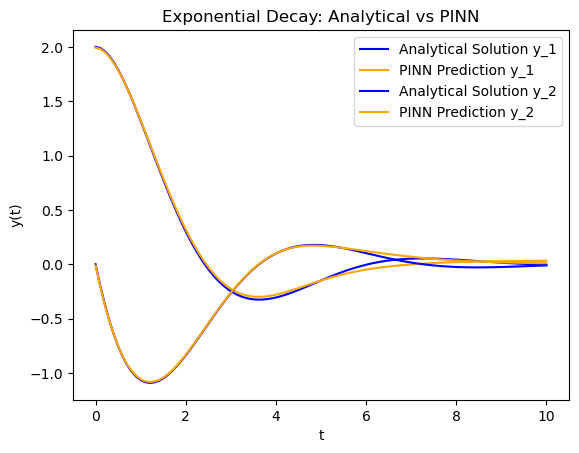

In [13]:
num_y = y_pred_np.shape[1]
for i in range(num_y):
    plt.plot(sol.t, sol.y.T[:, i], color='blue', label=f'Analytical Solution y_{i+1}')
    plt.plot(t_np, y_pred_np[:, i], color='orange', label=f'PINN Prediction y_{i+1}')

plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.title('Exponential Decay: Analytical vs PINN')
plt.show()